In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

import contractions
import unicodedata
import re
import inflect
import pickle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, confusion_matrix

import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

Using TensorFlow backend.


In [2]:
df = pd.read_csv("./../Data/Train_Data/train.csv")

In [3]:
df.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [4]:
def denoise_text(text):
    text = contractions.fix(text)
    return text

In [5]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [6]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [7]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [8]:
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

In [9]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

In [10]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [11]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [12]:
def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    #words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [13]:
# Testing the functions
print("remove_non_ascii results: ", remove_non_ascii(['h', 'ॐ', '©', '1']))
print("to_lowercase results: ", to_lowercase(['HELLO', 'hiDDen', 'wanT', 'GOING']))
print("remove_punctuation results: ", remove_punctuation(['hello!!', 'how?', 'done,']))
print("replace_numbers results: ", replace_numbers(['1', '2', '3']))
print("remove_stopwords results: ", remove_stopwords(['this', 'and', 'amazing']))
print("stem_words results: ", stem_words(['beautiful', 'flying', 'waited']))
print("lemmatize_verbs results: ", lemmatize_verbs(['hidden', 'walking', 'ran']))
print("normalize_text results: ", normalize_text(['hidden', 'in', 'the', 'CAVES', 'he', 'WAited', '2', 'ॐ', 'hours!!']))

remove_non_ascii results:  ['h', '', '', '1']
to_lowercase results:  ['hello', 'hidden', 'want', 'going']
remove_punctuation results:  ['hello', 'how', 'done']
replace_numbers results:  ['one', 'two', 'three']
remove_stopwords results:  ['amazing']
stem_words results:  ['beauty', 'fly', 'wait']
lemmatize_verbs results:  ['hide', 'walk', 'run']
normalize_text results:  ['hide', 'cav', 'wait', '2', 'hour']


In [14]:
def tokenize(text):
    return nltk.word_tokenize(text)

In [15]:
def text_prepare(text):
    text = denoise_text(text)
    text = ' '.join([x for x in normalize_text(tokenize(text))])
    return text

In [16]:
df['text'] = [text_prepare(x) for x in df['text']]

In [17]:
df.head(10)

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,ten best stat nobody ev com clos elev walk roo...,1,2.42,1.0,0.20
1,2,man insert advert class wif want next day rece...,1,2.50,1.0,1.10
2,3,many men tak op beer non op tim bring couch,1,1.95,0.0,2.40
3,4,tell mom hit 1200 twit follow point broth own ...,1,2.11,1.0,0.00
4,5,ros dead lov fak wed bas fun cak,1,2.78,0.0,0.10
5,6,trabajo span word work com latin term trepali ...,0,NaN,NaN,0.00
6,7,enrol skil train extr curricul act ad shap wee...,0,NaN,NaN,0.10
7,8,origin tru on kind also hold glass whit win lo...,1,1.79,1.0,0.00
8,9,men ejac 21 tim mon low risk prost cant ejac f...,0,NaN,NaN,0.05
9,10,get real angry today noth go tak word,0,NaN,NaN,0.15


In [21]:
df.to_csv('./../Data/preprocessed_train_data.csv')

In [18]:
texts = df.text.values
labels = df.is_humor.values

In [19]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW
import torch

In [20]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator',num_labels=2)
model.cuda()

INFO:filelock:Lock 1593372126232 acquired on C:\Users\keerr/.cache\torch\transformers\fe616facc71d8e3afc69de3edac76bf1e4a0a741e80d9a99a2cc6a9a8f5f74b5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


INFO:filelock:Lock 1593372126232 released on C:\Users\keerr/.cache\torch\transformers\fe616facc71d8e3afc69de3edac76bf1e4a0a741e80d9a99a2cc6a9a8f5f74b5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


INFO:filelock:Lock 1593371623664 acquired on C:\Users\keerr/.cache\torch\transformers\7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.2f3596f15f58505e0f3a1b5b28d8a37b25b653ee06d18272368f53df840e6323.lock


INFO:filelock:Lock 1593371623664 released on C:\Users\keerr/.cache\torch\transformers\7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.2f3596f15f58505e0f3a1b5b28d8a37b25b653ee06d18272368f53df840e6323.lock
INFO:filelock:Lock 1591301934720 acquired on C:\Users\keerr/.cache\torch\transformers\aed576b8aec823c870feda40d60bd803ac8e40056ecb7d7f43dd0b2bfd82e373.db390a2059e53ead2bb00e1a2f8cd50b0a47e1969d180cd70339ec3f6f29dce1.lock


INFO:filelock:Lock 1591301934720 released on C:\Users\keerr/.cache\torch\transformers\aed576b8aec823c870feda40d60bd803ac8e40056ecb7d7f43dd0b2bfd82e373.db390a2059e53ead2bb00e1a2f8cd50b0a47e1969d180cd70339ec3f6f29dce1.lock
Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mode

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

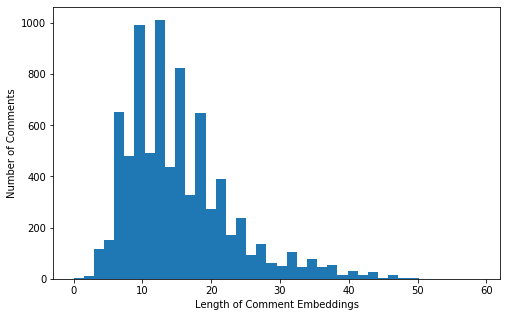

In [21]:
import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return
plot_sentence_embeddings_length(texts, tokenizer)

In [22]:
indices=tokenizer.batch_encode_plus(texts,max_length=64,add_special_tokens=True, 
                                    return_attention_mask=True,pad_to_max_length=True,truncation=True)

input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

C:\Users\keerr\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [23]:
from sklearn.model_selection import train_test_split

# Use 99% for training and 1% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [24]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [25]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [26]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [27]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [30]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [32]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    50  of    200.    Elapsed: 0:43:20.
  Batch   100  of    200.    Elapsed: 1:26:52.
  Batch   150  of    200.    Elapsed: 2:10:22.

  Average training loss: 0.55
  Training epoch took: 2:53:17

======== Epoch 2 / 5 ========
Training...
  Batch    50  of    200.    Elapsed: 0:45:52.
  Batch   100  of    200.    Elapsed: 2:10:59.
  Batch   150  of    200.    Elapsed: 2:57:37.

  Average training loss: 0.46
  Training epoch took: 3:22:49

======== Epoch 3 / 5 ========
Training...
  Batch    50  of    200.    Elapsed: 0:17:35.
  Batch   100  of    200.    Elapsed: 0:34:38.
  Batch   150  of    200.    Elapsed: 0:52:56.

  Average training loss: 0.40
  Training epoch took: 1:25:20

======== Epoch 4 / 5 ========
Training...
  Batch    50  of    200.    Elapsed: 0:17:35.
  Batch   100  of    200.    Elapsed: 0:37:12.
  Batch   150  of    200.    Elapsed: 0:54:42.

  Average training loss: 0.37
  Training epoch took: 1:11:55

======== Epoch 

In [33]:

print("")
print("Running Validation...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()

preds=[]
true=[]

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    preds.append(logits)
    true.append(label_ids)
    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...
  Accuracy: 0.82
  Validation took: 0:05:20


In [34]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true for item in sublist]

In [35]:
from sklearn.metrics import classification_report
print(classification_report(flat_predictions,flat_true_labels)) 

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       616
           1       0.85      0.85      0.85       984

    accuracy                           0.82      1600
   macro avg       0.81      0.81      0.81      1600
weighted avg       0.82      0.82      0.82      1600



In [43]:
df_test=pd.read_csv("./../Data/dev_data/public_dev.csv")

In [44]:
df_test['text'] = [text_prepare(x) for x in df_test['text']]

In [45]:
comments1 = df_test.text.values

indices1=tokenizer.batch_encode_plus(comments1,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)


# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

C:\Users\keerr\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [46]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader1:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids1, b_input_mask1 = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

    logits1 = outputs1[0]

    # Move logits and labels to CPU
    logits1 = logits1.detach().cpu().numpy()
  
  
    # Store predictions and true labels
    predictions.append(logits1)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

Predicting labels for 1,000 test sentences...


In [47]:
flat_predictions

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,

In [51]:
submit=pd.DataFrame({'id':df_test['id'].values.tolist(),'target':flat_predictions})

In [53]:
submit.to_csv('submission.csv', index=False)